In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
sys.path.append('../spock/')
from modelfitting import ROC_curve
try:
    plt.style.use('paper')
except:
    pass
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc 
from sklearn import metrics
from xgboost import XGBClassifier
sys.path.append('../../PlanetSysSurvivalTime/modules/')
import survivaltime as st

%matplotlib inline

In [2]:
df = pd.read_csv('../training_data/random/additional_featuresNorbits10000.0Nout80trio/trainingdata.csv', index_col=0)
labels = pd.read_csv('../training_data/random/additional_featuresNorbits10000.0Nout80trio/labels.csv', index_col=0)
df.head()

,EMfracstdnear,EPstdnear,AMDfracnear,MMRstrengthnear,betanear,AMDcritnear,EMcrossnear,jnear,knear,EMfracstdfar,...,Z07Stable_avg,Z07Stable_worstpair,deltaQ11inner,deltaQ11outer,deltaQ11avg,Q11log_instability_time_inner,Q11log_instability_time_outer,Q11log_instability_time_avg,Q11Stable_avg,Q11Stable_worstpair
0,0.017511,0.002935,0.178882,0.104761,5.899524,1.528816e-06,0.221502,4.0,1.0,0.085965,...,False,False,0.181336,0.231297,0.206317,6.199812,8.474201,7.234686,False,False
1,0.072425,0.011408,18.030819,0.031489,5.822156,2.887466e-08,0.190647,4.0,1.0,0.005881,...,False,False,0.160121,0.287636,0.223878,6.210605,8.176953,7.589789,False,False
2,0.034442,0.001506,0.762864,0.326185,2.399923,1.618682e-06,0.125660,6.0,1.0,0.016461,...,False,False,0.111632,0.418793,0.265212,2.888476,9.623663,7.075861,False,False
3,0.008561,0.002451,0.822371,0.012940,12.836670,6.619971e-08,0.216684,4.0,1.0,0.003955,...,False,False,0.178094,0.190585,0.184339,9.248119,9.342286,9.613325,True,True
4,0.551761,0.002103,9.891405,NaN,2.030812,3.426953e-10,0.024455,28.0,1.0,0.361442,...,False,False,0.032936,0.023871,0.028404,4.979716,2.579815,3.439946,False,False


In [3]:
masses = pd.read_csv('../training_data/random/massratios.csv', index_col=0)
pratios = pd.read_csv('../paper_plots/randomPratios.csv', index_col=0)
pratios.tail()

,runstring,instability_time,shadow_instability_time,Stable,Pratio21,Pratio32,beta12,beta23
24995,0024995.bin,1.843086e+04,5.927632e+04,False,1.268641,1.288944,14.522773,15.079252
24996,0024996.bin,1.868259e+03,2.336571e+03,False,1.182572,1.140159,9.552527,4.048412
24997,0024997.bin,6.939732e+04,1.870889e+04,False,1.984149,1.114816,25.850615,4.666121
24998,0024998.bin,3.230628e+04,2.883785e+04,False,1.084278,1.346270,8.336998,14.038862
24999,0024999.bin,1.000024e+09,1.000024e+09,True,1.510872,1.664467,12.553012,16.970720


In [4]:
df['m1'] = masses['m1']
df['m2'] = masses['m2']
df['m3'] = masses['m3']
df['Pratio21'] = pratios['Pratio21']
df['Pratio32'] = pratios['Pratio32']

In [5]:
def petit(row):
    row['P20tpred'] = st.Tsurv(1/row['Pratio21'], 1/row['Pratio32'], [row['m1'], row['m2'], row['m3']], m0=1, res=False, fudge=1)
    row['P20Stable'] = row['P20tpred'] >= 1e9
    return row

In [6]:
%%time
df = df.apply(petit, axis=1)

CPU times: user 43 s, sys: 1.06 s, total: 44.1 s
Wall time: 39 s


# Petit 2020

In [7]:
TPRP20 = (labels['Stable'] & df['P20Stable']).sum()/labels['Stable'].sum()
TPRP20

0.9998990816429508

In [8]:
FPRP20 = ((~labels['Stable']) & df['P20Stable']).sum()/(~labels['Stable']).sum()
FPRP20

0.7145981048306937

# Zhou 2007 avg

In [9]:
TPRZ07 = (labels['Stable'] & df['Z07Stable_avg']).sum()/labels['Stable'].sum()
TPRZ07

0.6294277929155313

In [10]:
FPRZ07 = ((~labels['Stable']) & df['Z07Stable_avg']).sum()/(~labels['Stable']).sum()
FPRZ07

0.04121661917699291

# Zhou 2007 worst pair

In [14]:
TPR = (labels['Stable'] & df['Z07Stable_worstpair']).sum()/labels['Stable'].sum()
TPR

0.34332425068119893

In [15]:
FPR = ((~labels['Stable']) & df['Z07Stable_worstpair']).sum()/(~labels['Stable']).sum()
FPR

0.0067589954277383875

# Quillen 2011 average

In [16]:
TPRQ11 = (labels['Stable'] & df['Q11Stable_avg']).sum()/labels['Stable'].sum()
TPRQ11

0.4458573014431325

In [17]:
FPRQ11 = ((~labels['Stable']) & df['Q11Stable_avg']).sum()/(~labels['Stable']).sum()
FPRQ11

0.10946922006493937

# Quillen 2011 worst pair

In [18]:
TPR = (labels['Stable'] & df['Q11Stable_worstpair']).sum()/labels['Stable'].sum()
TPR

0.30346149964678576

In [19]:
FPR = ((~labels['Stable']) & df['Q11Stable_worstpair']).sum()/(~labels['Stable']).sum()
FPR

0.07149956927970313

# How many total stable?

In [20]:
df['Q11Stable_avg'].sum()/labels.shape[0]

0.2428

In [21]:
df['Z07Stable_avg'].sum()/labels.shape[0]

0.27436

In [22]:
df['P20Stable'].sum()/labels.shape[0]

0.82768

In [23]:
labels['Stable'].sum()/labels.shape[0]

0.39636

# SPOCK comparisons

In [24]:
name='SPOCK'
filename='featureclassifier'
model = XGBClassifier()
model.load_model('../spock/models/'+filename+'.json')
testingdatafolder = '../training_data/random/featuresNorbits10000.0Nout80trio/'  

dataset = pd.read_csv(testingdatafolder+"trainingdata.csv", index_col = 0)
labels = pd.read_csv(testingdatafolder+"labels.csv", index_col=0)
features = dataset.columns.values

Nrows = int(0.8*dataset.shape[0])
y = labels['Stable'].iloc[Nrows:]
X = dataset[features].iloc[Nrows:]
preds = model.predict_proba(X)[:,1]
fpr, tpr, ROCthresholds = roc_curve(y, preds)
roc_auc = metrics.roc_auc_score(y, preds)

In [25]:
def spockTPR(FPR):
    threshindex = np.where(fpr > FPR)[0][0]
    pthresh = ROCthresholds[threshindex]
    stabs = preds > pthresh
    TPR = (y & stabs).sum()/y.sum()
    print('At an FPR of {0:.4f}, SPOCK has a TPR of {1:.3f}'.format(FPR, TPR))
    
spockTPR(FPRQ11)
spockTPR(FPRZ07)
spockTPR(FPRP20)

At an FPR of 0.1095, SPOCK has a TPR of 0.956
At an FPR of 0.0412, SPOCK has a TPR of 0.837
At an FPR of 0.7146, SPOCK has a TPR of 0.999


In [26]:
def spockFPR(TPR):
    threshindex = np.where(tpr > TPR)[0][0]
    pthresh = ROCthresholds[threshindex]
    stabs = preds > pthresh
    FPR = (~y & stabs).sum()/(~y).sum()
    print('At a TPR of {0:.3f}, SPOCK has an FPR of {1:.4f}'.format(TPR, FPR))
    
spockFPR(TPRQ11)
spockFPR(TPRZ07)
spockFPR(TPRP20)

At a TPR of 0.446, SPOCK has an FPR of 0.0026
At a TPR of 0.629, SPOCK has an FPR of 0.0092
At a TPR of 1.000, SPOCK has an FPR of 0.8449


# Models trained on resonant dataset

Test on full 25,000 random systems

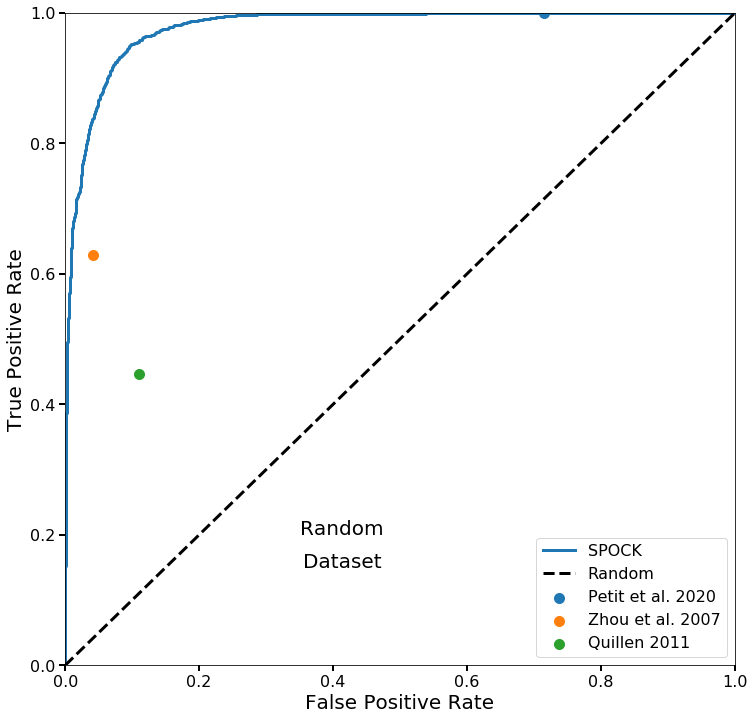

In [28]:
FPRthresh=0.1
TPRthresh=0.9
models = {'SPOCK':'spock', 'Hill':'hill'}
featuresdic = {'SPOCK':None, 'MEGNO':['MEGNO'], 'Hill':['betanear', 'betafar']}

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')


#print(name, "AUC = {0:.4f} Thresh = {1:.3f}".format(roc_auc, ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]), 
#"Thresh = {0:.3f}".format(ROCthresholds[tprthreshindex]),  "TPR = {0:.3f}".format(tpr[tprthreshindex]), "FPR = {0:.3f}".format(fpr[tprthreshindex]))
ax.plot(fpr, tpr, label='{0}'.format('SPOCK'))

ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')
ax.text(0.35, 0.2, "Random", fontsize=20)
ax.text(0.355, 0.15, "Dataset", fontsize=20)
ax.scatter(FPRP20, TPRP20, label='Petit et al. 2020')
ax.scatter(FPRZ07, TPRZ07, label='Zhou et al. 2007')
ax.scatter(FPRQ11, TPRQ11, label='Quillen 2011')

ax.legend()
#fig.savefig('QuillenZhouComparison.pdf', bbox_inches='tight')